# Comparison of Different galaxy properties
Ipython notebook to compare galaxy properties derived using different methods.

In [1]:
import numpy as np
import h5py
from pydl.pydlutils.spheregroup import spherematch
from ChangTools.fitstables import mrdfits

import matplotlib.pyplot as plt
from ChangTools.plotting import prettyplot
from ChangTools.plotting import prettycolors
%matplotlib inline 

/usr/local/lib/python2.7/site-packages/IPython/kernel/__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated. You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)


In [2]:
import pickle

## Read in heterogeneous data
VAGC Group Catalog both centrals and satellites from Jeremy

In [3]:
local_dir = '/Volumes/750GB/hahn/cenque/observations/'

In [4]:
# VAGC group catalog (all) M_r cut = 18
vagc_file = ''.join([local_dir, 'GroupCat.Mr18.Mass9.4.D360.all.hdf5']) 
f = h5py.File(vagc_file, 'r')
grp = f['data']

# save to dictionary
vagc = {}
for key in grp.keys(): 
    vagc[key] = grp[key].value

UV SFR from NSA (from Nitya)

In [5]:
#nsa_file = ''.join([local_dir, 'nsaid_ra_dec_z_mass_uvssfr'])
#nsa_dat = np.loadtxt(nsa_file, unpack=True, usecols=[1,2,3,4,5]) # ra, dec, z, mass (k-correct?), UV_ssfr
nsa_file = ''.join([local_dir, 'NSA_2MASS_UVSFR.p'])
nsa_dat = pickle.load(open(nsa_file, 'rb'))

In [41]:
# save to dictionary
nsa = {} 
nsa['ra'] = nsa_dat['ra']
nsa['dec'] = nsa_dat['dec']
nsa['z'] = nsa_dat['z']
nsa['mass'] = np.log10(nsa_dat['mass'])
nsa['sfr'] = np.log10(nsa_dat['sfr_uv_elpetro']) # arbitrarily chose Petrosian to be default
nsa['sfruv_elpetro'] = np.log10(nsa_dat['sfr_uv_elpetro'])
nsa['sfruv_sersic'] = np.log10(nsa_dat['sfr_uv_sersic'])
nsa['ssfr'] = nsa['sfr'] - nsa['mass']

nsa['absmag'] = nsa_dat['absmag']
nsa['absmag_nuv'] = nsa['absmag'][:,1]
nsa['absmag_r'] = nsa['absmag'][:,4]
nsa['absmag_j'] = nsa_dat['2mass_j_absmag_k20fe'] - 30.
nsa['absmag_h'] = nsa_dat['2mass_h_absmag_k20fe'] - 30.
nsa['absmag_k'] = nsa_dat['2mass_k_absmag_k20fe'] - 30.

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:6: RuntimeWarning: divide by zero encountered in log10
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:7: RuntimeWarning: divide by zero encountered in log10
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:7: RuntimeWarning: invalid value encountered in log10
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:8: RuntimeWarning: divide by zero encountered in log10
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:8: RuntimeWarning: invalid value encountered in log10
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log10
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:9: RuntimeWarning: invalid value encountered in log10


Salim et al. (2016) GSWLC catalog --- Catalog is generated from UV, Optical photometry

In [8]:
salim_file = ''.join([local_dir, 'GSWLC-D1.dat'])
# http://pages.iu.edu/~salims/gswlc/table.pdf 
#6 RA deg Right Ascension from SDSS
#7 Decl. deg Declination from SDSS
#8 z Redshift from SDSS
#9 χ2r Reduced goodnes-of-fit value for the SED fitting
#10 logM∗ M Stellar mass
#11 σ(logM∗) M Error of the stellar mass
#12 log SFRSED Myr−1 UV/optical (SED) star formation rate
#13 σ(log SFRSED) Myr−1 Error of the SFR
#14 AFUV mag Dust attenuation in rest-frame FUV
#15 σ(AFUV) mag Error of dust attenuation in FUV
#16 AB mag Dust attenuation in rest-frame B
#17 σ(AB) mag Error of dust attenuation in B
#18 AV mag Dust attenuation in rest-frame V
#19 σ(AV ) mag Error of dust attenuation in V
#20 flag_sed SED fitting flag (0 = OK, 1 = broad-line spectrum, 2 = χ2r > 30, 5 = missing SDSS photometry)
#21 UV survey 1 = GSWLC-A, 2 = GSWLC-M, 3 = GSWLC-D
#22 log SFRmid−IR,AW Myr−1 Mid-IR star formation rate from WISE (AllWISE catalog)
#23 flag_wise Mid-IR SFR (AllWISE) flag (0 = OK, 1 = no mid-IR SFR (low SSFR), 5 = no 22 µm detection)
#24 log SFRmid−IR,uW Myr−1 Mid-IR star formation rate from WISE (unWISE catalog)
#25 flag_unwise Mid-IR SFR (unWISE) flag (0 = OK, 1 = no mid-IR SFR (low SSFR), 5 = no 22 µm detection)
#26 flag_mgs 0 = not in SDSS Main Galaxy Sample (MGS), 1 = in MGS

salim_dat = np.loadtxt(salim_file, unpack=True)

# save to dictionary
salim = {} 
salim['ra'] = salim_dat[5]
salim['dec'] = salim_dat[6]
salim['z'] = salim_dat[7]
salim['mass'] = salim_dat[9]
salim['sfr'] = salim_dat[11]
salim['ssfr'] = salim['sfr'] - salim['mass'] 
salim['chi2'] = salim_dat[8]
salim['A_fuv'] = salim_dat[13]
salim['sig_A_fuv'] = salim_dat[14]
salim['A_b'] = salim_dat[15]
salim['sig_A_b'] = salim_dat[16]
salim['A_v'] = salim_dat[17]
salim['sig_A_v'] = salim_dat[18]
salim['flag_sed'] = salim_dat[19]
salim['sfr_allwise'] = salim_dat[21]
salim['flag_allwise'] = salim_dat[22]
salim['sfr_unwise'] = salim_dat[23]
salim['flag_unwise'] = salim_dat[24]

In [9]:
print len(salim['ra'])

48401


VAGC-GALEX with iSEDfit (John's catalog)

In [10]:
jm_kcorr_file = ''.join([local_dir, 'mf_parent_sdss.fits.gz'])
jm_kcorr_dat = mrdfits(jm_kcorr_file)

isedfit_file = ''.join([local_dir, 'ised_parent_supergrid01_sdss.fits.gz'])
isedfit_dat = mrdfits(isedfit_file)

if (np.abs(jm_kcorr_dat.zprimus - isedfit_dat.zobj)).max() != 0.: 
    raise ValueError

# save to dictionary
isedfit = {}
isedfit['ra'] = jm_kcorr_dat.ra
isedfit['dec'] = jm_kcorr_dat.dec
isedfit['z'] = isedfit_dat.zobj
isedfit['mass'] = isedfit_dat.mass_50
isedfit['sfr'] = isedfit_dat.sfr_50
isedfit['ssfr'] = isedfit['sfr'] - isedfit['mass']
isedfit['nuv'] = jm_kcorr_dat.k_fnuvugrizjhk_absmag_01[:,1]
isedfit['r'] = jm_kcorr_dat.k_fnuvugrizjhk_absmag_01[:,4]
isedfit['j'] = jm_kcorr_dat.k_fnuvugrizjhk_absmag_01[:,7]
isedfit['nuv-r'] = isedfit['nuv'] - isedfit['r']
isedfit['r-j'] = isedfit['r'] - isedfit['j']
isedfit['chi2'] = isedfit_dat.chi2
isedfit['A_v'] = isedfit_dat.av

## match up all the galaxy properties
anchored to the vagc values

In [11]:
# prepare for all the matches
for cat in ['nsa', 'salim', 'isedfit']:
    for key in ['id', 'ra', 'dec', 'z', 'mass', 'sfr', 'ssfr']: 
        vagc_key = ''.join([cat, '_', key])
        if key == 'id': 
            vagc[vagc_key] = np.repeat(-999, len(vagc['ra']))
        else: 
            vagc[vagc_key] = np.repeat(-999., len(vagc['ra']))

In [42]:
m_vagc_nsa, m_nsa_vagc, dd = spherematch(vagc['ra'], vagc['dec'], nsa['ra'], nsa['dec'], 0.001)

if len(m_vagc_nsa) != len(np.unique(m_vagc_nsa)): 
    raise ValueError

for key in ['id', 'ra', 'dec', 'z', 'mass', 'sfr', 'ssfr']: 
    if key == 'id': 
        vagc['nsa_id'][m_vagc_nsa] = m_nsa_vagc
    elif key == 'mass': # NAS masses cannot be trusted, replace with VAGC masses
        vagc['nsa_mass'][m_vagc_nsa] = vagc['mass'][m_vagc_nsa]
    else: 
        vagc['nsa_'+key][m_vagc_nsa] = nsa[key][m_nsa_vagc]

# re-compute NSA SSFR with VAGC stellar masses
vagc['nsa_ssfr'][m_vagc_nsa] = vagc['nsa_sfr'][m_vagc_nsa] - vagc['nsa_mass'][m_vagc_nsa]
vagc['nsa_sfruv_sersic'] = np.repeat(-999., len(vagc['ra']))
vagc['nsa_sfruv_sersic'][m_vagc_nsa] = nsa['sfruv_sersic'][m_nsa_vagc]

for band in ['nuv', 'r', 'j', 'h', 'k']: 
    vagc['nsa_absmag_'+band] = np.repeat(-999., len(vagc['ra']))
    vagc['nsa_absmag_'+band][m_vagc_nsa] = nsa['absmag_'+band][m_nsa_vagc]
print np.sum(vagc['nsa_id'] != -999), ' matches'

20312  matches


In [14]:
m_vagc_salim, m_salim_vagc, dd = spherematch(vagc['ra'], vagc['dec'], salim['ra'], salim['dec'], 0.001)

if len(m_vagc_salim) != len(np.unique(m_vagc_salim)): # make sure there's no repeats
    raise ValueError

vagc['salim_id'][m_vagc_salim] = m_salim_vagc
for key in salim.keys(): 
    try: 
        vagc['salim_'+key][m_vagc_salim] = salim[key][m_salim_vagc]
    except KeyError: 
        vagc['salim_'+key] = np.repeat(-999., len(vagc['ra']))
        vagc['salim_'+key][m_vagc_salim] = salim[key][m_salim_vagc]
        
print np.sum(vagc['salim_id'] != -999), ' matches'

1497  matches


In [15]:
m_vagc_isedfit, m_isedfit_vagc, dd = spherematch(vagc['ra'], vagc['dec'], isedfit['ra'], isedfit['dec'], 0.001)

if len(m_vagc_isedfit) != len(np.unique(m_vagc_isedfit)): # make sure there's no repeats
    raise ValueError

vagc['isedfit_nuv'] = np.repeat(-999., len(vagc['ra']))
vagc['isedfit_r'] = np.repeat(-999., len(vagc['ra']))
vagc['isedfit_j'] = np.repeat(-999., len(vagc['ra']))
vagc['isedfit_A_v'] = np.repeat(-999., len(vagc['ra']))
vagc['isedfit_chi2'] = np.repeat(-999., len(vagc['ra']))

for key in ['id', 'ra', 'dec', 'z', 'mass', 'sfr', 'ssfr', 'nuv', 'r', 'j', 'A_v', 'chi2']: 
    if key == 'id': 
        vagc['isedfit_id'][m_vagc_isedfit] = m_isedfit_vagc
    else: 
        vagc['isedfit_'+key][m_vagc_isedfit] = isedfit[key][m_isedfit_vagc]

print np.sum(vagc['isedfit_id'] != -999), ' matches'

5555  matches


## Mass comparison of the different catalogs

20312  matches out of  21423
1497  matches out of  21423
5555  matches out of  21423


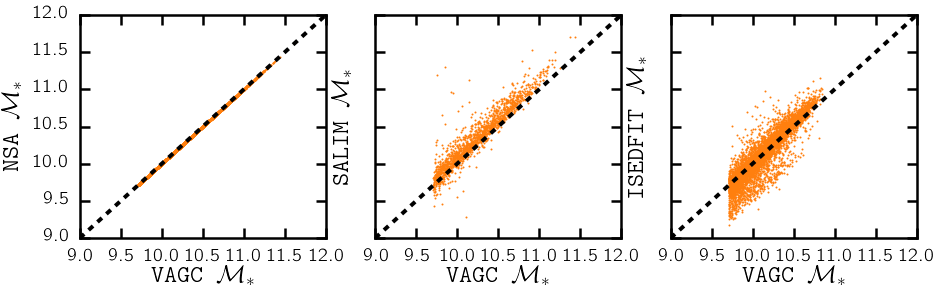

In [16]:
prettyplot()
pretty_colors = prettycolors()

fig = plt.figure(figsize=(15,4))
for i_sub, cat in enumerate(['nsa', 'salim', 'isedfit']): 
    sub = fig.add_subplot(1,3,i_sub+1)
    
    hasmatch = np.where(vagc[cat+'_id'] != -999)
    print len(hasmatch[0]), ' matches out of ', len(vagc['ra'])
    
    sub.scatter(vagc['mass'][hasmatch], vagc[cat+'_mass'][hasmatch], c=pretty_colors[3], lw=0, s=4)
    sub.plot([9.0, 12.], [9., 12.], c='k', ls='--', lw=4)
    #sub.plot([9.0, 12.], [9.2, 12.2], c='k', ls='--', lw=4)
    
    # x-axis
    sub.set_xlim([9., 12.])
    sub.set_xlabel('VAGC $\mathcal{M}_*$', fontsize=25)
    # y-axis 
    sub.set_ylim([9., 12.])
    sub.set_ylabel(cat.upper()+' $\mathcal{M}_*$', fontsize=25)
    if i_sub != 0: 
        sub.set_yticklabels([])
plt.show()

NSA stellar masses, which is supposed to be k-correct, is sytematically lower than the VAGC k-correct stellar masses. 

Salim's GSWLC catalog has systematically higher stellar masses than the VAGC. 

iSEDfit is roughly consistent with k-correct, with mild scatter. However, only 5555 matches...

## SFR comparison

20312  matches out of  21423
1497  matches out of  21423
5555  matches out of  21423


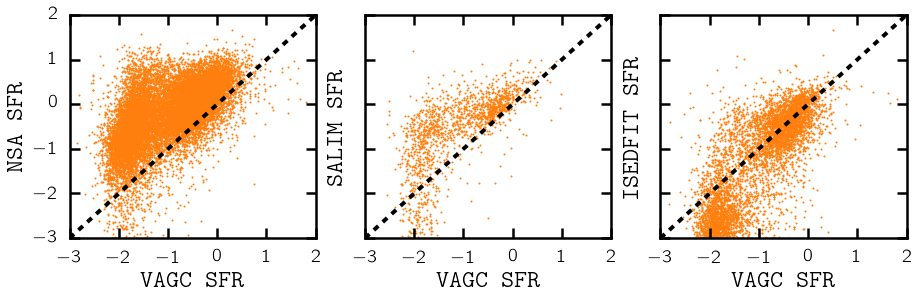

In [23]:
fig = plt.figure(figsize=(15,4))
for i_sub, cat in enumerate(['nsa', 'salim', 'isedfit']): 
    sub = fig.add_subplot(1,3,i_sub+1)
    
    hasmatch = np.where(vagc[cat+'_id'] != -999)
    print len(hasmatch[0]), ' matches out of ', len(vagc['ra'])
    #if cat == 'nsa': 
    #    sub.scatter(vagc['sfr'][hasmatch], vagc[cat+'_sfruv_sersic'][hasmatch], c=pretty_colors[3], lw=0, s=4)
    #else:
    sub.scatter(vagc['sfr'][hasmatch], vagc[cat+'_sfr'][hasmatch], c=pretty_colors[3], lw=0, s=4)
    sub.plot([-3., 3.], [-3., 3.], c='k', ls='--', lw=4)
    
    # x-axis
    sub.set_xlim([-3., 2.])
    sub.set_xlabel('VAGC SFR', fontsize=25)
    # y-axis 
    sub.set_ylim([-3., 2.])
    sub.set_ylabel(cat.upper()+' SFR', fontsize=25)
    if i_sub != 0: 
        sub.set_yticklabels([])
        
fig.savefig('sfr_comparison.png')
plt.show()

## SSFR comparison

20312  matches out of  21423
1497  matches out of  21423
5555  matches out of  21423


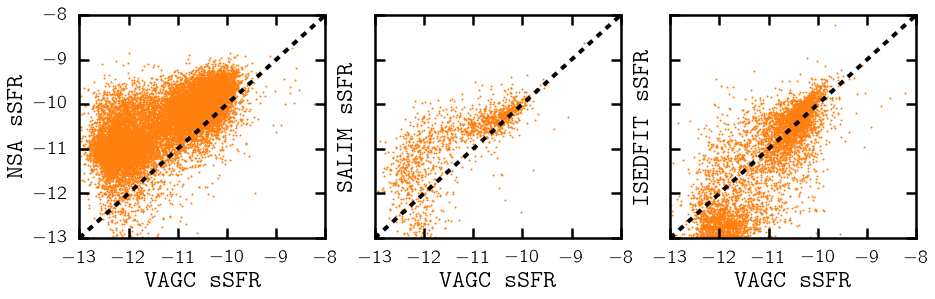

In [24]:
fig = plt.figure(figsize=(15,4))
for i_sub, cat in enumerate(['nsa', 'salim', 'isedfit']): 
    sub = fig.add_subplot(1,3,i_sub+1)
    
    hasmatch = np.where(vagc[cat+'_id'] != -999)
    print len(hasmatch[0]), ' matches out of ', len(vagc['ra'])
    
    sub.scatter(vagc['ssfr'][hasmatch], vagc[cat+'_ssfr'][hasmatch], c=pretty_colors[3], lw=0, s=4)
    sub.plot([-13., -8.], [-13., -8.], c='k', ls='--', lw=4)
    
    # x-axis
    sub.set_xlim([-13., -8.])
    sub.set_xlabel('VAGC sSFR', fontsize=25)
    # y-axis 
    sub.set_ylim([-13., -8.])
    sub.set_ylabel(cat.upper()+' sSFR', fontsize=25)
    if i_sub != 0: 
        sub.set_yticklabels([])
plt.show()

## SFR-M* comparison

20312  matches out of  21423
1497  matches out of  21423
5555  matches out of  21423


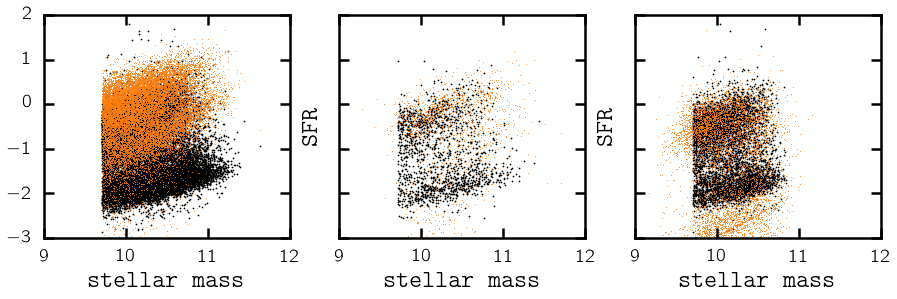

In [25]:
fig = plt.figure(figsize=(15,4))

for i_sub, cat in enumerate(['nsa', 'salim', 'isedfit']): 
    sub = fig.add_subplot(1,3,i_sub+1)
    hasmatch = np.where(vagc[cat+'_id'] != -999)
    print len(hasmatch[0]), ' matches out of ', len(vagc['ra'])
    
    sub.scatter(vagc['mass'][hasmatch], vagc['sfr'][hasmatch], c='k', lw=0, s=3)
    sub.scatter(vagc[cat+'_mass'][hasmatch], vagc[cat+'_sfr'][hasmatch], c=pretty_colors[3], lw=0, s=1)
    
    # x-axis
    sub.set_xlim([9., 12.])
    sub.set_xlabel('stellar mass', fontsize=25)
    sub.set_xticks([9., 10. ,11., 12.])
    # y-axis 
    sub.set_ylim([-3., 2.])
    if i_sub != 0: 
        sub.set_ylabel('SFR', fontsize=25)
        sub.set_yticklabels([])


## SFR/SSFR histogram comparison
SFR or SSFR histogram in bins of stellar mass

/usr/local/lib/python2.7/site-packages/numpy/lib/function_base.py:583: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= mn)
/usr/local/lib/python2.7/site-packages/numpy/lib/function_base.py:584: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= mx)


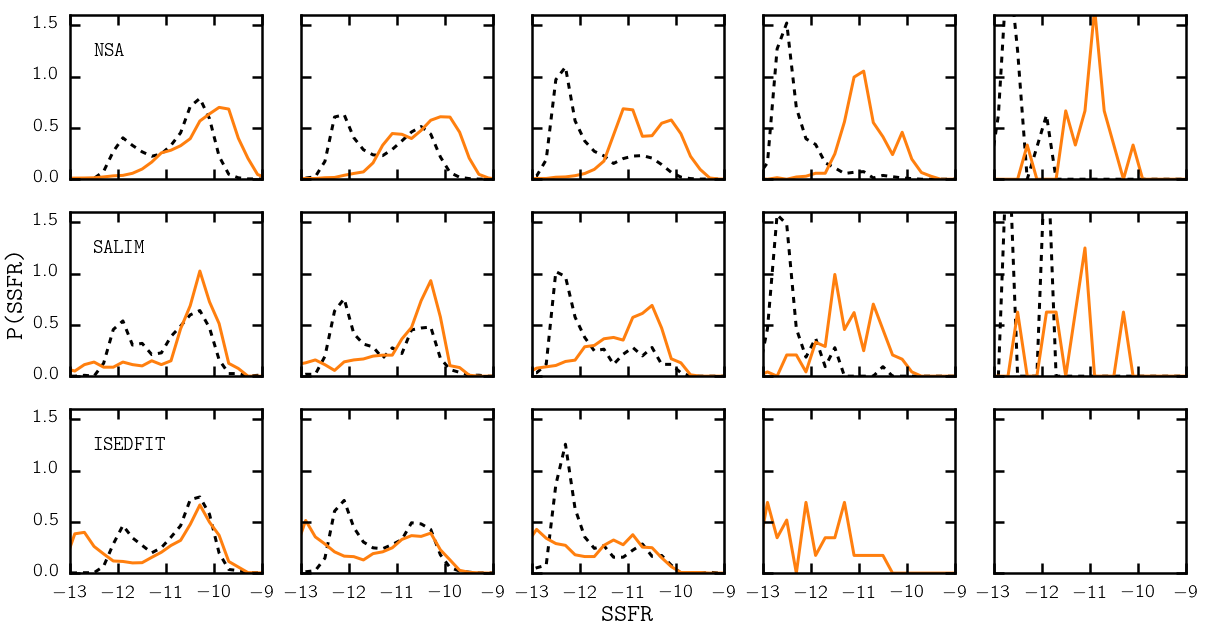

In [26]:
fig = plt.figure(figsize=(20,10))
bkgd = fig.add_subplot(111, frameon=False)
bkgd.tick_params(labelcolor='none', top='off', bottom='off', left='off', right='off')

mass_bins = [[9.7, 10.1], [10.1, 10.5], [10.5, 10.9], [10.9, 11.3], [11.3, 11.7]]

for i_cat, cat in enumerate(['nsa', 'salim', 'isedfit']):
    for i_sub, mass_bin in enumerate(mass_bins): 
        sub = fig.add_subplot(3, len(mass_bins), i_cat*len(mass_bins)+i_sub+1)
        in_massbin = np.where((vagc['mass'] >= mass_bin[0]) & (vagc['mass'] < mass_bin[1]) & (vagc[cat+'_id'] != -999))
        
        if len(in_massbin[0]) > 0: 
            p_ssfr, ssfr_bin_edge = np.histogram(vagc['ssfr'][in_massbin], range=[-15., -7.], bins=40, normed=True)

            sub.plot(0.5*(ssfr_bin_edge[:-1]+ssfr_bin_edge[1:]), p_ssfr, lw=3, ls='--', c='k')
        
        in_massbin2 = np.where((vagc[cat+'_mass'] >= mass_bin[0]) & (vagc[cat+'_mass'] < mass_bin[1]) & (vagc[cat+'_id'] != -999))
        if len(in_massbin2[0]) > 0: 
            p_ssfr, ssfr_bin_edge = np.histogram(vagc[cat+'_ssfr'][in_massbin2], range=[-15., -7.], bins=40, normed=True)
        
            sub.plot(0.5*(ssfr_bin_edge[:-1]+ssfr_bin_edge[1:]), p_ssfr, lw=3, c=pretty_colors[3])
        
        sub.set_xlim([-13., -9.])
        sub.set_xticks([-13., -12., -11., -10., -9.])
        sub.set_ylim([0., 1.6])
        sub.set_yticks([0., 0.5, 1., 1.5])
        if i_sub != 0: 
            sub.set_yticklabels([])
        else: 
            sub.text(-12.5, 1.2, cat.upper(), fontsize=20)
        if i_cat != 2: 
            sub.set_xticklabels([])

bkgd.set_xlabel('SSFR', fontsize=25)
bkgd.set_ylabel('P(SSFR)', fontsize=25)

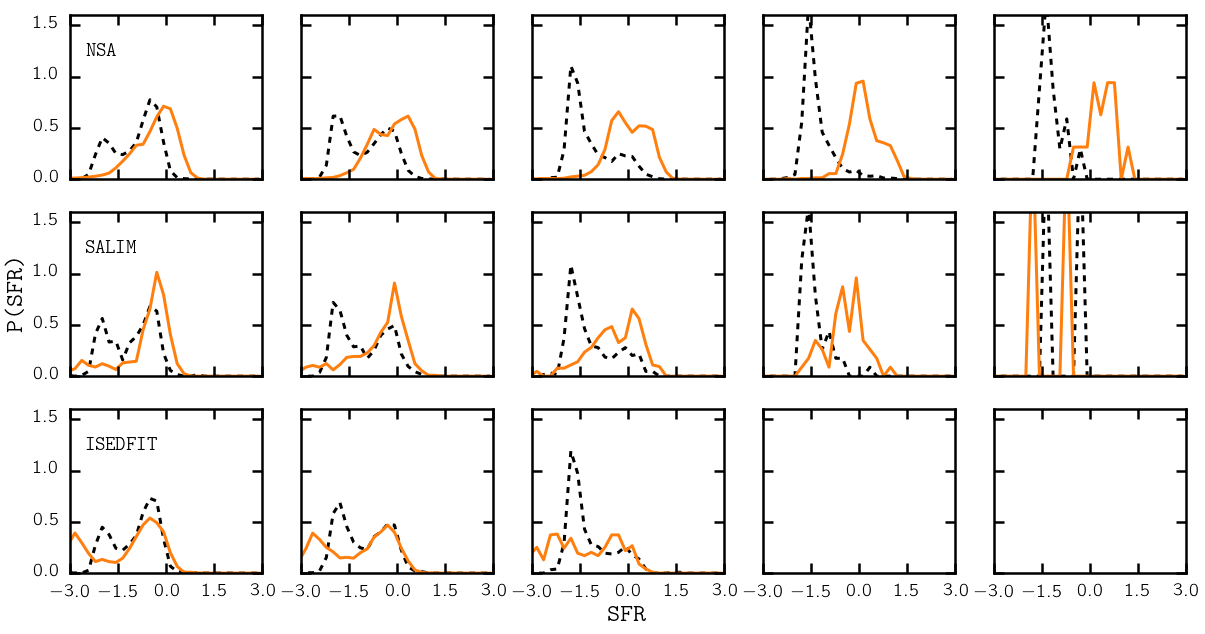

In [27]:
fig = plt.figure(figsize=(20,10))
bkgd = fig.add_subplot(111, frameon=False)
bkgd.tick_params(labelcolor='none', top='off', bottom='off', left='off', right='off')

mass_bins = [[9.7, 10.1], [10.1, 10.5], [10.5, 10.9], [10.9, 11.3], [11.3, 11.7]]

for i_cat, cat in enumerate(['nsa', 'salim', 'isedfit']):
    for i_sub, mass_bin in enumerate(mass_bins): 
        sub = fig.add_subplot(3, len(mass_bins), i_cat*len(mass_bins)+i_sub+1)
        in_massbin = np.where((vagc['mass'] >= mass_bin[0]) & (vagc['mass'] < mass_bin[1]) & (vagc[cat+'_id'] != -999))
        
        if len(in_massbin[0]) > 0: 
            p_ssfr, ssfr_bin_edge = np.histogram(vagc['sfr'][in_massbin], range=[-5.5, 3.], bins=40, normed=True)

            sub.plot(0.5*(ssfr_bin_edge[:-1]+ssfr_bin_edge[1:]), p_ssfr, lw=3, ls='--', c='k')
        
            p_ssfr, ssfr_bin_edge = np.histogram(vagc[cat+'_sfr'][in_massbin], range=[-5.5, 3.], bins=40, normed=True)
            #print vagc[cat+'_sfr'][in_massbin].min()
            sub.plot(0.5*(ssfr_bin_edge[:-1]+ssfr_bin_edge[1:]), p_ssfr, lw=3, c=pretty_colors[3])
        
        sub.set_xlim([-3., 3.])
        sub.set_xticks([-3, -1.5, 0, 1.5, 3.])
        sub.set_ylim([0., 1.6])
        sub.set_yticks([0., 0.5, 1., 1.5])
        if i_sub != 0: 
            sub.set_yticklabels([])
        else: 
            sub.text(-2.5, 1.2, cat.upper(), fontsize=20)
        if i_cat != 2: 
            sub.set_xticklabels([])

bkgd.set_xlabel('SFR', fontsize=25)
bkgd.set_ylabel('P(SFR)', fontsize=25)

## Check iSEDfit galaxies

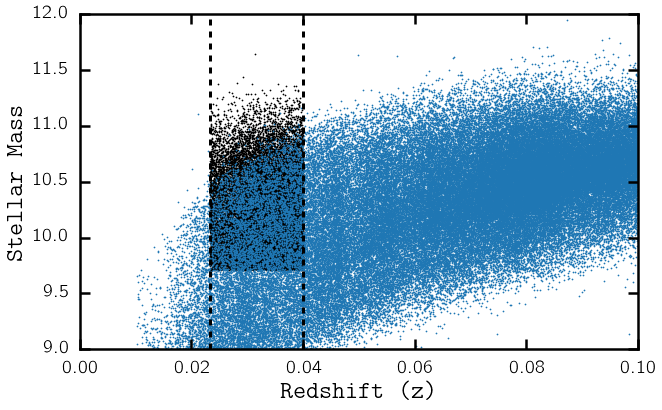

In [28]:
fig = plt.figure(figsize=(10,6))
sub = fig.add_subplot(111)
sub.scatter(vagc['z'], vagc['mass'], c='k', s=3, lw=0)
sub.scatter(isedfit['z'], isedfit['mass'], c=pretty_colors[1], s=3, lw=0)
sub.vlines(vagc['z'].min(), 9.0, 12., lw=3, linestyle='--', color='k')
sub.vlines(vagc['z'].max(), 9.0, 12., lw=3, linestyle='--', color='k')
sub.set_xlim([0., 0.1])
sub.set_xlabel('Redshift (z)', fontsize=25)
sub.set_ylim([9., 12.])
sub.set_ylabel('Stellar Mass', fontsize=25)

## Investigate galaxies that have significant SFR discrepancy between VAGC and GSWLC

In [ ]:
secret_sf = np.where(
    (vagc['salim_id'] != -999) & 
    (vagc['sfr'] < -1.5) & # low sfr in VAGC
    (vagc['salim_sfr'] > -1.)) # high SFR in Salim
print len(secret_sf[0])

In [ ]:
salim_match = np.where(vagc['salim_id'] != -999)

fig = plt.figure(figsize=(5,5))
sub = fig.add_subplot(111)
sub.scatter(vagc['sfr'][salim_match], vagc['salim_sfr'][salim_match], c=pretty_colors[3], lw=0)
sub.scatter(vagc['sfr'][secret_sf], vagc['salim_sfr'][secret_sf], c='k', lw=0)
sub.plot([-3., 3.], [-3., 3.], c='k', lw=3, ls='--')
sub.set_xlabel('SFR (VAGC)')
sub.set_xlim([-3., 2.,])
sub.set_ylabel('SFR (GSWLC)')
sub.set_ylim([-3., 2.,])

In [ ]:
fig = plt.figure(figsize=(5,5))
sub = fig.add_subplot(111)
sub.scatter(vagc['mass'][salim_match], vagc['salim_mass'][salim_match], c=pretty_colors[3], lw=0)
sub.scatter(vagc['mass'][secret_sf], vagc['salim_mass'][secret_sf], c='k')
sub.plot([9.,12.], [9.,12.], c='k', lw=3, ls='--')
sub.set_xlabel('$\mathcal{M}_*$ (VAGC)')
sub.set_xlim([9., 12.])
sub.set_ylabel('$\mathcal{M}_*$ (GSWLC)')
sub.set_ylim([9., 12.])

### Examine dust attenuation of these galaxies $A_{FUV}, A_{B}, A_{V}$

In [ ]:
fig = plt.figure(figsize=(15,5))

for i_dust, dust_index in enumerate(['fuv', 'b', 'v']):
    sub = fig.add_subplot(1,3,i_dust+1)
    #print vagc['salim_A_'+dust_index][salim_match].min(), vagc['salim_A_'+dust_index][salim_match].max()
    #print np.min(vagc['salim_A_'+dust_index][salim_match][np.where(vagc['salim_A_'+dust_index][salim_match] > -99.)])
    
    if dust_index == 'fuv': 
        A_upper = 5.5
    elif dust_index == 'b': 
        A_upper = 1.2
    elif dust_index == 'v': 
        A_upper = 1.
    p_afuv, afuv_bin = np.histogram(vagc['salim_A_'+dust_index][salim_match], range=[0., A_upper], bins=20)
    sub.plot(0.5*(afuv_bin[:-1]+afuv_bin[1:]), p_afuv, c='k', lw=3)
    #print np.float(len(np.where(vagc['salim_A_'+dust_index][salim_match] == -99.)[0]))/np.float(len(salim_match[0]))

    p_afuv, afuv_bin = np.histogram(vagc['salim_A_'+dust_index][secret_sf], range=[0., A_upper], bins=20)
    sub.plot(0.5*(afuv_bin[:-1]+afuv_bin[1:]), p_afuv, c=pretty_colors[3], lw=3)
    #print np.float(len(np.where(vagc['salim_A_'+dust_index][secret_sf] == -99.)[0]))/np.float(len(secret_sf[0]))
    sub.set_xlim([0., A_upper])
    sub.set_xlabel('$A_{'+dust_index.upper()+'}$', fontsize=25)
    if i_dust == 0: 
        sub.set_ylabel('P(dust attenutation)', fontsize=25)
    sub.set_title('$A_{'+dust_index.upper()+'}$', fontsize=25)

### What about their $\chi^2_r$

In [ ]:
fig = plt.figure(figsize=(10,5))
sub = fig.add_subplot(111)

p_chi2, chi2_bin = np.histogram(vagc['salim_chi2'][salim_match], range=[0., 25.], bins=40)
sub.plot(0.5*(chi2_bin[:-1]+chi2_bin[1:]), p_chi2, c='k', lw=3)

p_chi22, chi2_bin = np.histogram(vagc['salim_chi2'][secret_sf], range=[0., 25.], bins=40)
sub.plot(0.5*(chi2_bin[:-1]+chi2_bin[1:]), p_chi22, c=pretty_colors[3], lw=3)
sub.set_xlim([0., 25.])
sub.set_xlabel('Reduced $\chi^2$', fontsize=25)
sub.set_ylim([0., 100.])
sub.set_ylabel('P($\chi^2$)', fontsize=25)

In [ ]:
# flag_sed SED fitting flag (0 = OK, 1 = broad-line spectrum, 2 = χ2 r > 30, 5 = missing SDSS photometry)
print 'Salim Matches: '
print '0 = ', np.float(np.sum(vagc['salim_flag_sed'][salim_match] == 0))/np.float(len(salim_match[0])) 
print '1 = ', np.float(np.sum(vagc['salim_flag_sed'][salim_match] == 1))/np.float(len(salim_match[0])) 
print '2 = ', np.float(np.sum(vagc['salim_flag_sed'][salim_match] == 2))/np.float(len(salim_match[0]))

print 'SFR mis-matches'
print '0 = ', np.float(np.sum(vagc['salim_flag_sed'][secret_sf] == 0))/np.float(len(secret_sf[0])) 
print '1 = ', np.float(np.sum(vagc['salim_flag_sed'][secret_sf] == 1))/np.float(len(secret_sf[0])) 
print '2 = ', np.float(np.sum(vagc['salim_flag_sed'][secret_sf] == 2))/np.float(len(secret_sf[0]))

In [ ]:
fig = plt.figure(figsize=(10,5))
bkgd = fig.add_subplot(111, frameon=False)
bkgd.tick_params(labelcolor='none', top='off', bottom='off', left='off', right='off')

sub = fig.add_subplot(121)

sub.scatter(vagc['sfr'][salim_match], vagc['salim_sfr_allwise'][salim_match], c=pretty_colors[3], lw=0)
sub.scatter(vagc['sfr'][secret_sf], vagc['salim_sfr_allwise'][secret_sf], c='k', lw=0)
sub.plot([-3., 3.], [-3.,3.], lw=3, ls='--', c='k')
sub.set_xlim([-3., 2.])
sub.set_ylim([-3., 2.])
sub.set_ylabel('SFR (all WISE)')

sub = fig.add_subplot(122)
sub.scatter(vagc['sfr'][salim_match], vagc['salim_sfr_unwise'][salim_match], c=pretty_colors[3], lw=0)
sub.scatter(vagc['sfr'][secret_sf], vagc['salim_sfr_unwise'][secret_sf], c='k', lw=0)
sub.plot([-3., 3.], [-3.,3.], lw=3, ls='--', c='k')
sub.set_xlim([-3., 2.])
sub.set_ylim([-3., 2.])
sub.set_ylabel('SFR (un-WISE)')

bkgd.set_xlabel('SFR (VAGC)', fontsize=25)

### What about compared to iSEDfit? 

In [ ]:
ised_salim_match = np.where((vagc['isedfit_id'] != -999) & (vagc['salim_id'] != -999))
ised_salim_discrep = np.where((vagc['isedfit_id'] != -999) & (vagc['salim_id'] != -999) & 
                             (vagc['isedfit_sfr'] < -1.5) & (vagc['salim_sfr'] > -1))

fig = plt.figure(figsize=(6,6))
sub = fig.add_subplot(111)
sub.scatter(vagc['isedfit_sfr'][ised_salim_match], vagc['salim_sfr'][ised_salim_match], lw=0, c=pretty_colors[3])
sub.scatter(vagc['isedfit_sfr'][ised_salim_discrep], vagc['salim_sfr'][ised_salim_discrep], lw=0, c='k')
sub.plot([-3., 3.], [-3., 3.], lw=3, ls='--', c='k')
sub.set_xlabel('SFR (iSEDfit)', fontsize=25)
sub.set_xlim([-3., 2.])
sub.set_ylabel('SFR (GSWLC)', fontsize=25)
sub.set_ylim([-3., 2.])

In [ ]:
fig = plt.figure(figsize=(12,6))
sub = fig.add_subplot(111)
print vagc['isedfit_chi2'][ised_salim_match].max()
sub.scatter(vagc['isedfit_chi2'][ised_salim_match], vagc['salim_chi2'][ised_salim_match], lw=0, c=pretty_colors[3])
sub.scatter(vagc['isedfit_chi2'][ised_salim_discrep], vagc['salim_chi2'][ised_salim_discrep], lw=0, c='k')
#sub.plot([-3., 3.], [-3., 3.], lw=3, ls='--', c='k')
sub.set_xlabel('$\chi^2$ (iSEDfit)', fontsize=25)
sub.set_xlim([-1., 100.])
sub.set_ylabel('$\chi^2_r$ (GSWLC)', fontsize=25)
sub.set_ylim([-1., 25.])

In [ ]:
fig = plt.figure(figsize=(12,6))
sub = fig.add_subplot(111)
print vagc['isedfit_chi2'][ised_salim_match].max()
p_chi2_ised, chi2_bin = np.histogram(vagc['isedfit_chi2'][ised_salim_match], range=[0.,100.], bins=50)
sub.plot(0.5*(chi2_bin[:-1]+chi2_bin[1:]), p_chi2_ised, c=pretty_colors[3], lw=3)

p_chi2_ised, chi2_bin = np.histogram(vagc['isedfit_chi2'][ised_salim_discrep], range=[0., 100.], bins=50)
sub.plot(0.5*(chi2_bin[:-1]+chi2_bin[1:]), p_chi2_ised, c='k', lw=3)
#sub.plot([-3., 3.], [-3., 3.], lw=3, ls='--', c='k')
sub.set_xlabel('$\chi^2$ (iSEDfit)', fontsize=25)
sub.set_xlim([-1., 100.])
sub.set_ylabel('P($\chi^2$)', fontsize=25)
sub.set_yscale('log')
#sub.set_ylim([-1., 25.])

In [ ]:
fig = plt.figure(figsize=(12,6))
sub = fig.add_subplot(111)
p_av, av_bin = np.histogram(vagc['isedfit_A_v'][ised_salim_match], range=[0., 4.0], bins=20)
sub.plot(0.5*(av_bin[:-1]+av_bin[1:]), p_av, c=pretty_colors[3], lw=3)

p_av, av_bin = np.histogram(vagc['isedfit_A_v'][ised_salim_discrep], range=[0., 4.0], bins=20)
sub.plot(0.5*(av_bin[:-1]+av_bin[1:]), p_av, c='k', lw=3)

#sub.scatter(vagc['isedfit_A_v'][ised_salim_discrep], vagc['salim_A_v'][ised_salim_discrep], lw=0, c='k')
#sub.plot([-3., 3.], [-3., 3.], lw=3, ls='--', c='k')
sub.set_xlabel('$A_v$ (iSEDfit)', fontsize=25)
sub.set_xlim([0., 4.])
sub.set_ylabel('P($A_V$)', fontsize=25)
#sub.set_ylim([0., 1.])

In [ ]:
fig = plt.figure(figsize=(6,6))
sub = fig.add_subplot(111)
print vagc['isedfit_A_v'][ised_salim_match].max()
sub.scatter(vagc['isedfit_A_v'][ised_salim_match], vagc['salim_A_v'][ised_salim_match], lw=0, c=pretty_colors[3])
sub.scatter(vagc['isedfit_A_v'][ised_salim_discrep], vagc['salim_A_v'][ised_salim_discrep], lw=0, c='k')
#sub.plot([-3., 3.], [-3., 3.], lw=3, ls='--', c='k')
sub.set_xlabel('$A_v$ (iSEDfit)', fontsize=25)
sub.set_xlim([0., 4.])
sub.set_ylabel('$A_V$ (GSWLC)', fontsize=25)
sub.set_ylim([0., 1.])


These galaxies are not particularly dusty...

# $f_Q$ comparison
In Hahn et al. (2016) SDSS galaxies are classified based on SFR-M* relation. 

(-3.0, 2.0)

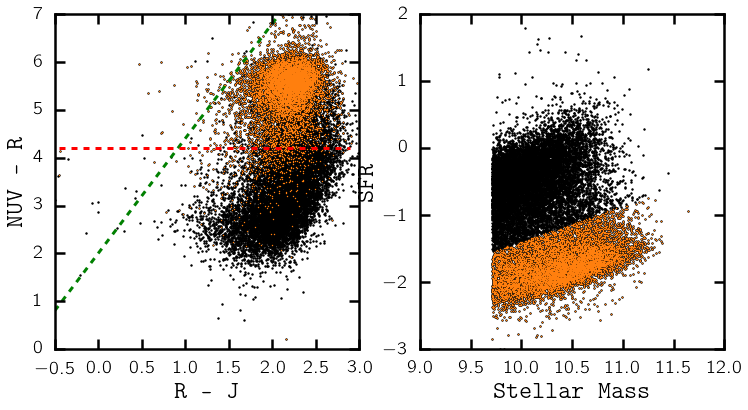

In [46]:
#NUV-r vs r-j
nsa_match = np.where(vagc['nsa_id'] != -999)

fig = plt.figure(figsize=(12,6))
sub = fig.add_subplot(121)
sub.scatter(vagc['nsa_absmag_r'][nsa_match] - vagc['nsa_absmag_j'][nsa_match], 
            vagc['nsa_absmag_nuv'][nsa_match] - vagc['nsa_absmag_r'][nsa_match], 
           c='k', s=2)
sub.plot(np.arange(-1., 3., 0.1), 2.0 + 2.4*np.arange(-1., 3., 0.1), c='g', lw=3, ls='--')
sub.plot(np.arange(-1., 3., 0.1), 4.2 + 0.*np.arange(-1., 3.,0.1), c='r', lw=3, ls='--')

nsa_match_Q = np.where((vagc['nsa_id'] != -999) & (vagc['sfr'] < 0.53 * (vagc['mass'] - 10.5)+ 1.1 * (vagc['z'] - 0.0502) - 1.11))

sub.scatter(vagc['nsa_absmag_r'][nsa_match_Q] - vagc['nsa_absmag_j'][nsa_match_Q], 
            vagc['nsa_absmag_nuv'][nsa_match_Q] - vagc['nsa_absmag_r'][nsa_match_Q], 
           c=pretty_colors[3], s=2, lw=0)
sub.set_xlabel('R - J', fontsize=25)
sub.set_xlim([-0.5, 3.])
sub.set_ylabel('NUV - R', fontsize=25)
sub.set_ylim([0., 7.])

sub = fig.add_subplot(122)
sub.scatter(vagc['mass'][nsa_match], vagc['sfr'][nsa_match], c='k', s=2)
sub.scatter(vagc['mass'][nsa_match_Q], vagc['sfr'][nsa_match_Q], c=pretty_colors[3], lw=0, s=2)
sub.set_xlabel('Stellar Mass', fontsize=25)
sub.set_xlim([9., 12.])
sub.set_ylabel('SFR', fontsize=25)
sub.set_ylim([-3., 2.])

In [ ]:
#NUV-r vs r-j
ised_match = np.where(vagc['isedfit_id'] != -999)

fig = plt.figure(figsize=(12,6))
sub = fig.add_subplot(121)
sub.scatter(vagc['isedfit_r'][ised_match] - vagc['isedfit_j'][ised_match], 
            vagc['isedfit_nuv'][ised_match] - vagc['isedfit_r'][ised_match], 
           c='k', s=2)

sub.plot(np.arange(-1., 3., 0.1), 2.0 + 2.4*np.arange(-1., 3., 0.1), c='g', lw=3, ls='--')
sub.plot(np.arange(-1., 3., 0.1), 4.2 + 0.*np.arange(-1., 3.,0.1), c='r', lw=3, ls='--')

ised_match_Q = np.where((vagc['isedfit_id'] != -999) & (vagc['sfr'] < 0.53 * (vagc['mass'] - 10.5)+ 1.1 * (vagc['z'] - 0.0502) - 1.11))

sub.scatter(vagc['isedfit_r'][ised_match_Q] - vagc['isedfit_j'][ised_match_Q], 
            vagc['isedfit_nuv'][ised_match_Q] - vagc['isedfit_r'][ised_match_Q], 
           c=pretty_colors[3], s=2, lw=0)
sub.set_xlabel('R - J', fontsize=25)
sub.set_xlim([-0.5, 2.])
sub.set_ylabel('NUV - R', fontsize=25)
sub.set_ylim([0., 7.])

sub = fig.add_subplot(122)
sub.scatter(vagc['mass'][ised_match], vagc['sfr'][ised_match], c='k', s=2)
sub.scatter(vagc['mass'][ised_match_Q], vagc['sfr'][ised_match_Q], c=pretty_colors[3], lw=0, s=2)
sub.set_xlabel('Stellar Mass', fontsize=25)
sub.set_xlim([9., 12.])
sub.set_ylabel('SFR', fontsize=25)
sub.set_ylim([-3., 2.])

In [ ]:
#NUV-r vs r-j
ised_match = np.where(vagc['isedfit_id'] != -999)

fig = plt.figure(figsize=(12,6))
sub = fig.add_subplot(121)
sub.scatter(vagc['isedfit_r'][ised_match] - vagc['isedfit_j'][ised_match], 
            vagc['isedfit_nuv'][ised_match] - vagc['isedfit_r'][ised_match], 
           c='k', s=2)

sub.plot(np.arange(-1., 3., 0.1), 2.0 + 2.4*np.arange(-1., 3., 0.1), c='g', lw=3, ls='--')
sub.plot(np.arange(-1., 3., 0.1), 4.2 + 0.*np.arange(-1., 3.,0.1), c='r', lw=3, ls='--')

ised_match_Q = np.where((vagc['isedfit_id'] != -999) & 
                        (vagc['isedfit_nuv']-vagc['isedfit_r'] > 2.0 + 2.4*(vagc['isedfit_r']-vagc['isedfit_j'])) &
                        (vagc['isedfit_nuv']-vagc['isedfit_r'] > 4.2))

sub.scatter(vagc['isedfit_r'][ised_match_Q] - vagc['isedfit_j'][ised_match_Q], 
            vagc['isedfit_nuv'][ised_match_Q] - vagc['isedfit_r'][ised_match_Q], 
           c=pretty_colors[3], s=2, lw=0)
sub.set_xlabel('R - J', fontsize=25)
sub.set_xlim([-0.5, 2.])
sub.set_ylabel('NUV - R', fontsize=25)
sub.set_ylim([0., 7.])

sub = fig.add_subplot(122)
sub.scatter(vagc['mass'][ised_match], vagc['sfr'][ised_match], c='k', s=2)
sub.scatter(vagc['mass'][ised_match_Q], vagc['sfr'][ised_match_Q], c=pretty_colors[3], lw=0, s=2)
sub.set_xlabel('Stellar Mass', fontsize=25)
sub.set_xlim([9., 12.])
sub.set_ylabel('SFR', fontsize=25)
sub.set_ylim([-3., 2.])

In [ ]:
nuv_r_j_FQ = []
sfms_FQ = [] 
mass_bins = np.arange(9.0, 12., 0.2)
for i_m in range(len(mass_bins)-1): 
    in_mbin_ised = np.where((vagc['isedfit_id'] != -999) & 
                       (vagc['mass'] > mass_bins[i_m]) &
                       (vagc['mass'] <= mass_bins[i_m+1]))
    rj_mbin_ised = vagc['isedfit_r'][in_mbin_ised] - vagc['isedfit_j'][in_mbin_ised]
    nuvj_mbin_ised = vagc['isedfit_nuv'][in_mbin_ised] - vagc['isedfit_r'][in_mbin_ised] 
    N_Q_nuvrj = np.float(np.sum((nuvj_mbin_ised > 4.2) & (nuvj_mbin_ised > 2.0 + 2.4 * rj_mbin_ised)))
    
    N_Q_sfms = np.float(np.sum(vagc['sfr'][in_mbin_ised] < 0.53 * (vagc['mass'][in_mbin_ised] - 10.5)+ 1.1 * (vagc['z'][in_mbin_ised] - 0.0502) - 1.11))
    
    N_tot_mbin = np.float(len(in_mbin_ised[0]))
    if N_tot_mbin == 0.: 
        nuv_r_j_FQ.append(0.)
        sfms_FQ.append(0.)
    else: 
        nuv_r_j_FQ.append(N_Q_nuvrj/N_tot_mbin)
        sfms_FQ.append(N_Q_sfms/N_tot_mbin)

In [ ]:
fig = plt.figure(figsize=(6,6))
bkgd = fig.add_subplot(111, frameon=False)
bkgd.tick_params(labelcolor='none', top='off', bottom='off', left='off', right='off')

for i_z in range(len(cosmos_zbins)): 
    sub = fig.add_subplot(111)
    if i_z == 0: 
        sub.plot(cosmos_qfz036[0], cosmos_qfz036[1], color=pretty_colors[i_z+1], lw=3)
    elif i_z == 1: 
        sub.plot(cosmos_qfz066[0], cosmos_qfz066[1], color=pretty_colors[i_z+1], lw=3)        
    elif i_z == 2: 
        sub.plot(cosmos_qfz088[0], cosmos_qfz088[1], color=pretty_colors[i_z+1], lw=3)
        
    sub.scatter(primus_qf_zbins[i_z][0], primus_qf_zbins[i_z][1], c=pretty_colors[i_z+1], lw=0, s=25,
                label='-'.join([str(zz) for zz in cosmos_zbins[i_z]]))
    
    sub.set_xlim([9.0, 12.])
    sub.set_xticks([9., 10., 11., 12.])
    sub.set_ylim([0.005, 1.])
    #sub.set_yscale("log")
    #if i_z != 0: 
    #    sub.set_yticklabels([])
sub.legend(loc='lower right', scatterpoints=1)
bkgd.set_xlabel('stellar mass', fontsize=25)
bkgd.set_ylabel('$f_Q$', fontsize=25)

In [ ]:
fig = plt.figure(figsize=(6,6))
sub = fig.add_subplot(111)
sub.plot(0.5*(mass_bins[:-1]+mass_bins[1:]), sfms_FQ, c='k', lw=3)
sub.plot(0.5*(mass_bins[:-1]+mass_bins[1:]), nuv_r_j_FQ, c=pretty_colors[3], lw=3, ls='--')
sub.set_xlim([9.0, 11.5])
sub.set_ylim([0.,1.])